In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier

## Загрузка данных

In [2]:
df = pd.read_csv('data/df_out.csv')
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


In [3]:
df.shape

(10000, 20)

## 2. Data Preparation

### 2.1 Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

#### 2.1.1 Преобразование типа данных

In [5]:
df.odometer = df.odometer.astype(int)
df['date'] = pd.to_datetime(df['posting_date'], utc=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              10000 non-null  int64              
 1   url             10000 non-null  object             
 2   region          10000 non-null  object             
 3   region_url      10000 non-null  object             
 4   price           10000 non-null  int64              
 5   year            9964 non-null   float64            
 6   manufacturer    10000 non-null  object             
 7   model           9872 non-null   object             
 8   fuel            9937 non-null   object             
 9   odometer        10000 non-null  int32              
 10  title_status    9834 non-null   object             
 11  transmission    9955 non-null   object             
 12  image_url       9998 non-null   object             
 13  description     9998 non-null   

#### 2.1.2 Пропущенные значения

In [7]:
# Количество полностью заполненных объектов и их процент из всей выборки
def print_useful_rows_info(df):
    print ('Количество полностью заполненных объектов из всей выборки:',
           len(df.dropna()))
    print ('Процент полностью заполненных объектов из всей выборки: ', 
          round(len(df.dropna()) / len(df) * 100, 2))
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки:  95.07


In [8]:
# Процент пропущенных значений для каждого признака
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print('Процент пропущенных значений:\n', missing_values)

Процент пропущенных значений:
 title_status      1.66
model             1.28
long              0.98
lat               0.98
fuel              0.63
transmission      0.45
year              0.36
posting_date      0.02
description       0.02
image_url         0.02
date              0.02
url               0.00
odometer          0.00
manufacturer      0.00
state             0.00
price             0.00
region_url        0.00
region            0.00
price_category    0.00
id                0.00
dtype: float64


In [9]:
# Cписок всех признаков, в которых имеются пропущенные значения
missing_columns = missing_values[missing_values.values > 0].index.tolist()
missing_columns

['title_status',
 'model',
 'long',
 'lat',
 'fuel',
 'transmission',
 'year',
 'posting_date',
 'description',
 'image_url',
 'date']

In [10]:
df = df[df.posting_date.notna()]
df.transmission = df.transmission.fillna('other')
df = df[~(df.long.isna() | df.lat.isna())]
df = df[df.year.notna()]
df.model = df.model.fillna('other')
df.title_status = df.title_status.fillna('df.title_status.mode()')
df.fuel = df.fuel.fillna('other')

In [11]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9868
Процент полностью заполненных объектов из всей выборки:  100.0


In [12]:
df.year = df.year.astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9868 non-null   int64              
 1   url             9868 non-null   object             
 2   region          9868 non-null   object             
 3   region_url      9868 non-null   object             
 4   price           9868 non-null   int64              
 5   year            9868 non-null   int32              
 6   manufacturer    9868 non-null   object             
 7   model           9868 non-null   object             
 8   fuel            9868 non-null   object             
 9   odometer        9868 non-null   int32              
 10  title_status    9868 non-null   object             
 11  transmission    9868 non-null   object             
 12  image_url       9868 non-null   object             
 13  description     9868 non-null   o

#### 2.1.3 Выбросы

In [14]:
# Выбросы года выпуска
df.year.describe()

count    9868.000000
mean     2010.909708
std         9.705988
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [15]:
# Границы для нормальных значений года выпуска
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [16]:
boundaries = calculate_outliers(df['year'])
is_outlier = (df['year'] < boundaries[0]) | (df['year'] > boundaries[1])
print('Границы:', boundaries)
print('Количество выбросов в годе выпуска автомобиля:', is_outlier.sum())
print('Доля выбросов в годе выпуска автомобиля:', is_outlier.sum() / len(df))

Границы: (1994.5, 2030.5)
Количество выбросов в годе выпуска автомобиля: 394
Доля выбросов в годе выпуска автомобиля: 0.03992703688690717


In [17]:
# Значения для категории цены для записей, в которых год выпуска автомобиля является выбросом
df_out = df[is_outlier]
is_outlier_price_category = (df['price_category'] == 'high')
df_out[is_outlier_price_category]

C:\Users\mamakenga\AppData\Local\Temp\ipykernel_9544\17640461.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_out[is_outlier_price_category]


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25T10:10:43-0500,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29T10:49:29-0700,high,2021-04-29 17:49:29+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29T15:11:01-0600,high,2021-04-29 21:11:01+00:00
416,7314286382,https://charlotte.craigslist.org/cto/d/hudson-...,charlotte,https://charlotte.craigslist.org,42500,1968,chevrolet,corvette,gas,4594,clean,manual,https://images.craigslist.org/00A0A_dWpo2a2QZS...,Up For Sale Is A Gorgeous 1968 427 Big Block C...,nc,28.364800,-82.675700,2021-04-29T10:09:40-0400,high,2021-04-29 14:09:40+00:00
562,7306382847,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,37000,1969,mercury,cougar xr7,gas,34000,clean,automatic,https://images.craigslist.org/00h0h_5Em4aIVQ3Y...,1969 Mercury Cougar XR 7 Out of the shop last ...,az,34.568658,-112.410049,2021-04-13T14:17:08-0700,high,2021-04-13 21:17:08+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9406,7307317218,https://waterloo.craigslist.org/ctd/d/cedar-fa...,waterloo / cedar falls,https://waterloo.craigslist.org,59995,1963,chevrolet,corvette,gas,0,clean,manual,https://images.craigslist.org/00l0l_3e1oZ9coiq...,1963 *** Chevrolet Corvette stingray *** D...,ia,42.504823,-92.405569,2021-04-15T13:30:28-0500,high,2021-04-15 18:30:28+00:00
9706,7310693442,https://tricities.craigslist.org/cto/d/clayton...,tri-cities,https://tricities.craigslist.org,23000,1964,chevrolet,nova,gas,80000,clean,automatic,https://images.craigslist.org/00i0i_8IS7DaNEg1...,"$$$$$ PRICE REDUCED 64 CHEVY NOVA, 355 ENGINE,...",tn,35.634800,-78.451000,2021-04-21T23:07:58-0400,high,2021-04-22 03:07:58+00:00
9765,7304378729,https://baltimore.craigslist.org/cto/d/elma-sp...,baltimore,https://baltimore.craigslist.org,29000,1968,dodge,dart srt,gas,1,clean,automatic,https://images.craigslist.org/00o0o_1BuRI812Rq...,1968 DODGE DART GS BIG BLOCK ORIGINAL BUILD S...,md,42.834000,-78.634300,2021-04-09T17:00:51-0400,high,2021-04-09 21:00:51+00:00
9859,7316395713,https://seattle.craigslist.org/see/ctd/d/sherm...,seattle-tacoma,https://seattle.craigslist.org,35500,1965,pontiac,gto,gas,61009,clean,manual,https://images.craigslist.org/00C0C_k6h7Uzc55e...,1965 Pontiac GTO. VIN: 237375P248569. True GTO...,wa,33.637200,-96.618400,2021-05-03T13:06:11-0700,high,2021-05-03 20:06:11+00:00


In [18]:
# Заменим выбросы года выуска нижней границей
df.loc[is_outlier, 'year'] = int(boundaries[0])

In [19]:
df.year.describe()

count    9868.000000
mean     2011.658391
std         6.530991
min      1994.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

In [20]:
df.shape

(9868, 20)

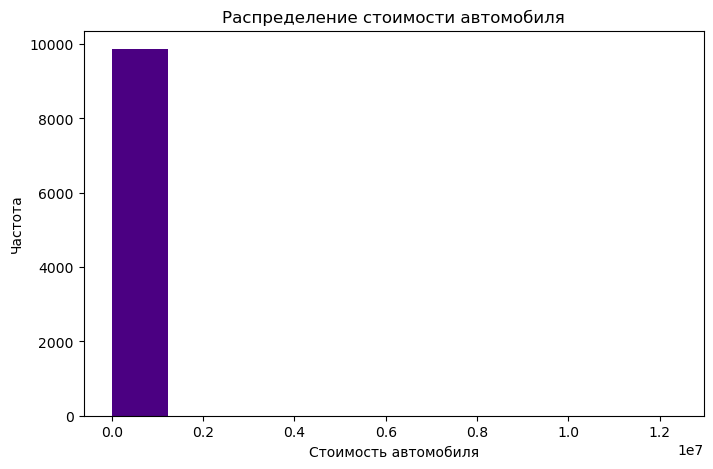

In [21]:
# Выбросы стоимости автомобиля
plt.figure(figsize = (8, 5))
plt.hist(df.price, color = 'indigo')
plt.xlabel('Стоимость автомобиля')
plt.ylabel('Частота')
plt.title('Распределение стоимости автомобиля');

In [22]:
# Можно сделать вывод о наличии выбросов

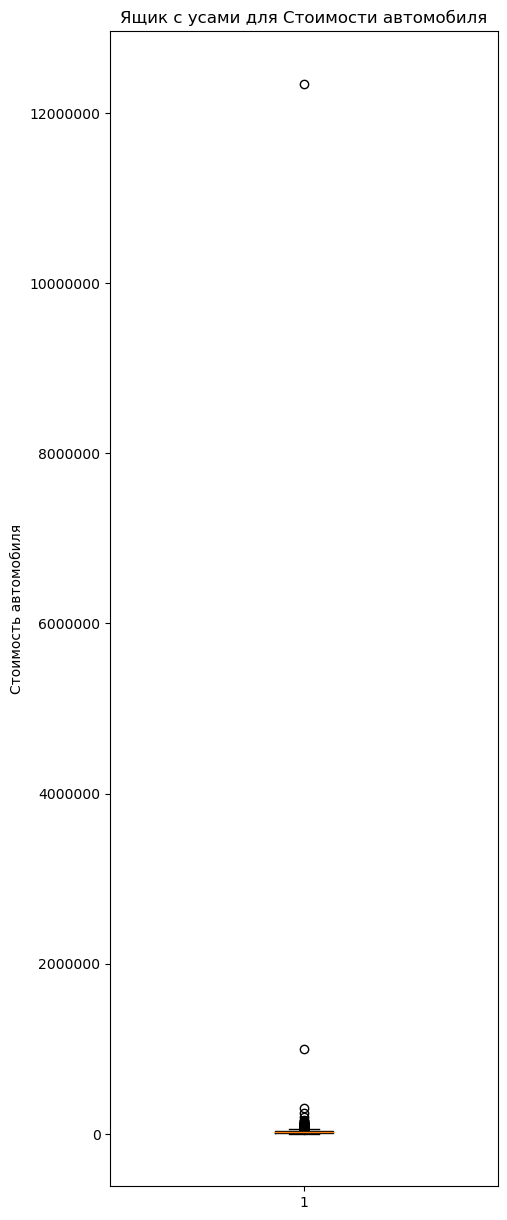

In [23]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize = (5, 15))
ax.boxplot(df.price)
ax.set_ylabel('Стоимость автомобиля')
ax.set_title('Ящик с усами для Стоимости автомобиля')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [24]:
# Описательные статистики стоимости автомобиля 
df.price.describe().apply(lambda x: f"{x:0.3f}")

count        9868.000
mean        20602.005
std        125437.186
min           500.000
25%          7800.000
50%         15590.000
75%         27990.000
max      12345678.000
Name: price, dtype: object

In [25]:
boundaries_price = calculate_outliers(df.price)
is_outlier_price = (df.price < boundaries_price[0]) | (df.price > boundaries_price[1])

print('Границы:', boundaries_price)
print('Количество выбросов в стоимости автомобиля:', is_outlier_price.sum())
print('Доля выбросов в годе выпуска автомобиля:', is_outlier_price.sum() / len(df))

Границы: (-22485.0, 58275.0)
Количество выбросов в стоимости автомобиля: 207
Доля выбросов в годе выпуска автомобиля: 0.020976895014187272


In [26]:
# Записи, в которых стоимость автомобиля попадает в выбросы, отсортированные по стоимости
df_outlier_price = df[is_outlier_price].sort_values(by = 'price')
df_outlier_price.tail(15)

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
4133,7311841843,https://albuquerque.craigslist.org/ctd/d/albuq...,albuquerque,https://albuquerque.craigslist.org,120000,2021,chevrolet,corvette c8 z51,gas,10,clean,automatic,https://images.craigslist.org/00z0z_99zXyVvNmm...,New arrival Z51 Call or text annamarie for d...,nm,35.081800,-106.648200,2021-04-24T08:38:45-0600,high,2021-04-24 14:38:45+00:00
1699,7303398175,https://pullman.craigslist.org/cto/d/pullman-6...,pullman / moscow,https://pullman.craigslist.org,123456,1994,other,cadvwrambuick,gas,283466,missing,other,https://images.craigslist.org/00i0i_5iBwIawLgG...,I have several cars to get rid of: A '65 Ramb...,id,46.735200,-117.172900,2021-04-07T15:57:23-0700,high,2021-04-07 22:57:23+00:00
9194,7308732637,https://evansville.craigslist.org/ctd/d/evansv...,evansville,https://evansville.craigslist.org,123456,2006,jeep,wrangler,gas,12345,clean,other,https://images.craigslist.org/00I0I_2IkqjY69Zq...,Very Nice TJ jeeps and a few LJ jeep wranglers...,in,38.025845,-87.596457,2021-04-18T09:55:42-0500,high,2021-04-18 14:55:42+00:00
3006,7308463617,https://jacksonville.craigslist.org/cto/d/pont...,jacksonville,https://jacksonville.craigslist.org,129000,2018,mercedes-benz,benz amg gt c,gas,4000,clean,automatic,https://images.craigslist.org/00C0C_bN8j4IcEqW...,Beautiful car in perfect condition. Very rare ...,fl,30.122300,-81.362700,2021-04-17T16:48:42-0400,high,2021-04-17 20:48:42+00:00
5149,7314445453,https://boston.craigslist.org/gbs/ctd/d/methue...,boston,https://boston.craigslist.org,129995,2007,ferrari,f430 spider,gas,12351,clean,manual,https://images.craigslist.org/00q0q_3DqREXHC0j...,2007 Ferrari F430 Spider 2dr Convertible O...,ma,42.756205,-71.210258,2021-04-29T14:45:08-0400,high,2021-04-29 18:45:08+00:00
6566,7312384300,https://orlando.craigslist.org/ctd/d/orlando-2...,orlando,https://orlando.craigslist.org,129999,2018,mercedes-benz,maybach s560,gas,6000,clean,automatic,https://images.craigslist.org/00u0u_fKyDNpMeQR...,"Serious/ready buyers, please call or text @ (4...",fl,28.463700,-81.394800,2021-04-25T12:58:01-0400,high,2021-04-25 16:58:01+00:00
9024,7314817013,https://sandiego.craigslist.org/csd/ctd/d/dall...,san diego,https://sandiego.craigslist.org,139950,2017,other,Mclaren 570GT W/ Upgrades,gas,13000,clean,automatic,https://images.craigslist.org/00N0N_2egaCVi4pq...,SPECIALTYEXOTICS.COMCALL/TXT 469-215-1902FREE ...,ca,32.790400,-96.804400,2021-04-30T08:20:20-0700,high,2021-04-30 15:20:20+00:00
4245,7316319465,https://portland.craigslist.org/clc/ctd/d/glad...,portland,https://portland.craigslist.org,149990,2015,mercedes-benz,sprinter 3500 airs,diesel,49291,clean,automatic,https://images.craigslist.org/00B0B_79v5I132cL...,2015 Mercedes-Benz Sprinter 3500 Airstream Int...,or,45.382346,-122.605132,2021-05-03T11:04:09-0700,high,2021-05-03 18:04:09+00:00
8840,7313664504,https://austin.craigslist.org/cto/d/austin-sup...,austin,https://austin.craigslist.org,150000,2006,other,Peterbilt 378,diesel,1234,clean,manual,https://images.craigslist.org/00v0v_ejAvqrK3iP...,Selling a Wonderful Super Dump! 2006 Peterbilt...,tx,30.364900,-97.682700,2021-04-27T21:01:28-0500,high,2021-04-28 02:01:28+00:00
9164,7306718413,https://desmoines.craigslist.org/ctd/d/portlan...,des moines,https://desmoines.craigslist.org,163540,2020,mercedes-benz,other,other,6318,clean,automatic,https://images.craigslist.org/00y0y_i26NvL7pZC...,2020 *** Mercedes-Benz G-Class G63 AMG*** ...,ia,45.494265,-122.579192,2021-04-14T11:26:24-0500,high,2021-04-14 16:26:24+00:00


Среди автомобилей с аномальной стоимостью действительно присуствуют автомобили, высокую стоимость которых можно объяснить, в первучю очередь, производителем и низким пробегом. Но будем опираться на стоимость основной массы автомобилей и удаляем все аномальные значения.

In [27]:
df_outlier_price.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
946,7312212565,https://lasvegas.craigslist.org/cto/d/fresno-d...,las vegas,https://lasvegas.craigslist.org,58500,2013,ram,3500 limited,diesel,57149,clean,automatic,https://images.craigslist.org/00o0o_6VEbwgYoL0...,Only 57K Miles! This 3500 RAM Truck has the 6....,nv,36.746400,-119.639700,2021-04-24T20:46:06-0700,high,2021-04-25 03:46:06+00:00
6060,7310551940,https://cincinnati.craigslist.org/ctd/d/camp-d...,cincinnati,https://cincinnati.craigslist.org,58500,2019,chevrolet,"silverado 2500hd 4wd crew cab 153.7"" ltz",other,50930,clean,automatic,https://images.craigslist.org/01010_ldls5xr3zz...,***Call Us for more information at: 513-453-41...,oh,39.171991,-84.271999,2021-04-21T17:05:31-0400,high,2021-04-21 21:05:31+00:00
4853,7308933629,https://omaha.craigslist.org/cto/d/cortland-20...,omaha / council bluffs,https://omaha.craigslist.org,58500,2008,chevrolet,corvette,gas,11000,clean,manual,https://images.craigslist.org/00P0P_kxzGxZwBY9...,2008 Corvette Z06 Wil Cooksey Edition Car nu...,ia,40.445488,-96.713695,2021-04-18T15:53:04-0500,high,2021-04-18 20:53:04+00:00
8163,7307146509,https://lubbock.craigslist.org/ctd/d/brownfiel...,lubbock,https://lubbock.craigslist.org,58600,2019,ford,f-150,gas,29458,clean,automatic,https://images.craigslist.org/00E0E_6JF7CBAVf7...,Stanley CDJR Brownfield address: 1706 Lubbo...,tx,33.196047,-102.273565,2021-04-15T08:58:48-0500,high,2021-04-15 13:58:48+00:00
1271,7313450196,https://lasvegas.craigslist.org/ctd/d/salem-20...,las vegas,https://lasvegas.craigslist.org,58670,2016,chevrolet,other,other,16407,clean,automatic,https://images.craigslist.org/00000_e7iiMwUVq3...,2016 *** Chevrolet Corvette 2LZ Z06*** ...,nv,44.927304,-123.030322,2021-04-27T11:29:39-0700,high,2021-04-27 18:29:39+00:00


In [28]:
df = df.loc[~ is_outlier_price]

In [29]:
df.shape

(9661, 20)

#### 2.1.4 Исследование зависимости стоимости автомобиля от года производства

In [30]:
# Cтатистика о годе производства автомобиля и среднем значении стоимости автомобиля за этот год
stats = df.groupby(['year'], as_index = False)[['price']].mean()
stats = stats.rename(columns = {'price': 'price_mean'})
stats

,year,price_mean
0,1994,13528.049223
1,1995,9610.060606
2,1996,9362.960000
3,1997,6441.250000
4,1998,6528.672727
5,1999,7446.641975
6,2000,7614.410256
7,2001,7852.090164
8,2002,7173.798658
9,2003,7767.962162


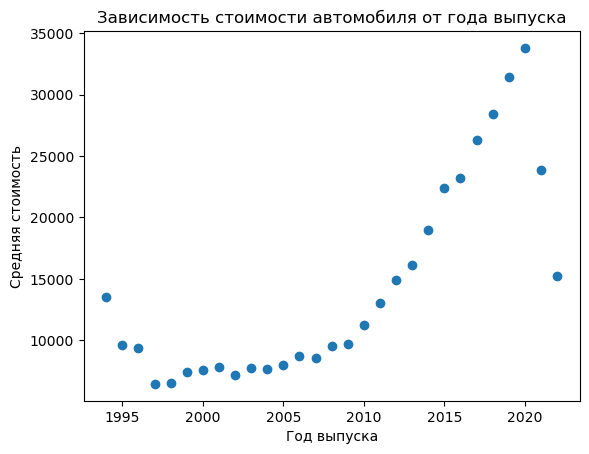

In [31]:
plt.figure()
plt.scatter(stats['year'], stats['price_mean'])
plt.title('Зависимость стоимости автомобиля от года выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя стоимость');

Из графика можно сделать вывод о возрастающем тренде: чем новее автомобиль, тем выше его цена. Исключение составляют наиболее старые и самые новые автомобили.  

In [32]:
# количество автомобилей, произведенных в каждый год
stats_2 = df.groupby(['year'], as_index = False)[['price']].count()
stats_2 = stats_2.rename(columns = {'price': 'count'})
stats_2

,year,count
0,1994,386
1,1995,33
2,1996,25
3,1997,44
4,1998,55
5,1999,81
6,2000,78
7,2001,122
8,2002,149
9,2003,185


In [33]:
# За последние два года мало накопленной информации — исключим их из исследования

In [34]:
df = df[df['year'] <= 2021]

In [35]:
df.shape

(9659, 20)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              9659 non-null   int64              
 1   url             9659 non-null   object             
 2   region          9659 non-null   object             
 3   region_url      9659 non-null   object             
 4   price           9659 non-null   int64              
 5   year            9659 non-null   int32              
 6   manufacturer    9659 non-null   object             
 7   model           9659 non-null   object             
 8   fuel            9659 non-null   object             
 9   odometer        9659 non-null   int32              
 10  title_status    9659 non-null   object             
 11  transmission    9659 non-null   object             
 12  image_url       9659 non-null   object             
 13  description     9659 non-null   o

## 3. Feature engineering

### 3.1 Генерация дополнительных строковых фичей

In [37]:
# Выразим пробег в километрах и проверим корреляцию
df['odometer_km'] = df.apply(lambda x: x.odometer  * 1.609344, axis=1)
df['odometer_km'].corr(df['odometer'])

1.0

In [38]:
df.odometer_km

0        44163.618048
1        96597.654912
2        22608.064512
3       188761.567104
4        12874.752000
            ...      
9995    241401.600000
9996    182778.026112
9997    241697.719296
9998     99687.595392
9999     57809.245824
Name: odometer_km, Length: 9659, dtype: float64

In [39]:
# Введем переменную отношения количества пройденых миль к цене
df['odometer/price'] = df.apply(lambda x: x.odometer / x.price, axis=1)
cor_odometer = df['odometer/price'].corr(df['odometer'])
cor_price = df['odometer/price'].corr(df['price'])
print('Корреляция с количеством пройденных миль:' , cor_odometer)
print('Корреляция с ценой автомобиля:' , cor_price)

Корреляция с количеством пройденных миль: 0.5190758111472743
Корреляция с ценой автомобиля: -0.4903668494365143


In [40]:
# Проверим связаны ли колонки регион и URL региона
df['region_new'] = df.region_url.apply(lambda x: x.lower().split('://')[1].split('.')[0])
df['region_new']

0        chattanooga
1          newjersey
2               reno
3       fayetteville
4            newyork
            ...     
9995      chautauqua
9996      binghamton
9997           salem
9998         madison
9999         norfolk
Name: region_new, Length: 9659, dtype: object

In [41]:
df['region_new'].nunique()

405

In [42]:
df['region'].nunique()

393

In [43]:
df[df['region'] != df['region_new']]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,odometer_km,odometer/price,region_new
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,96597.654912,3.542852,newjersey
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,22608.064512,0.394718,reno
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,12874.752000,0.366972,newyork
6,7316793777,https://desmoines.craigslist.org/ctd/d/martens...,des moines,https://desmoines.craigslist.org,6700,2015,ford,fusion se,gas,149000,...,"2015 Ford Fusion SE, 2.5 4 cyl. automatic, air...",ia,41.373000,-93.735800,2021-05-04T11:59:42-0500,low,2021-05-04 16:59:42+00:00,239792.256000,22.238806,desmoines
8,7315031640,https://grandrapids.craigslist.org/ctd/d/wyomi...,grand rapids,https://grandrapids.craigslist.org,14000,2014,dodge,charger,gas,94535,...,2014 Dodge Charger 4dr Sdn SXT RWD Offered...,mi,42.914352,-85.730042,2021-04-30T17:20:30-0400,medium,2021-04-30 21:20:30+00:00,152139.335040,6.752500,grandrapids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,7316175335,https://orangecounty.craigslist.org/cto/d/hunt...,orange county,https://orangecounty.craigslist.org,1575,1994,other,1988 Nisan,gas,120000,...,Really good running 88 Nissan. Has Sun roof. B...,ca,33.654019,-117.980606,2021-05-03T07:19:18-0700,low,2021-05-03 14:19:18+00:00,193121.280000,76.190476,orangecounty
9992,7306374320,https://cnj.craigslist.org/ctd/d/trenton-2000-...,central NJ,https://cnj.craigslist.org,3000,2000,lincoln,ls,gas,161969,...,"2000 Lincoln LS Base 4dr V8 Sedan -- $$3,000 ...",nj,40.181570,-74.663384,2021-04-13T17:01:41-0400,low,2021-04-13 21:01:41+00:00,260663.838336,53.989667,cnj
9993,7315504125,https://appleton.craigslist.org/ctd/d/fond-du-...,appleton-oshkosh-FDL,https://appleton.craigslist.org,8999,2013,dodge,grand caravan,gas,114730,...,2013 Dodge Grand Caravan SE Mini-Van Drive i...,wi,43.790599,-88.446483,2021-05-01T16:01:36-0500,low,2021-05-01 21:01:36+00:00,184640.037120,12.749194,appleton
9994,7305898015,https://fayar.craigslist.org/ctd/d/lowell-2015...,fayetteville,https://fayar.craigslist.org,22900,2015,ram,1500,diesel,151942,...,2015 RAM Ram Pickup 1500 4X4... THIS RAM IS LO...,ar,36.255400,-94.130800,2021-04-12T17:15:35-0500,high,2021-04-12 22:15:35+00:00,244526.946048,6.635022,fayar


In [44]:
df[df['region'] != df['region_new']].region.unique()

array(['north jersey', 'reno / tahoe', 'new york city', 'des moines',
       'grand rapids', 'omaha / council bluffs', 'rhode island',
       'seattle-tacoma', 'hawaii', 'fresno / madera', 'inland empire',
       'south jersey', 'new haven', 'ft myers / SW florida',
       'tyler / east TX', 'corpus christi', 'appleton-oshkosh-FDL',
       'las vegas', 'greenville / upstate', 'anchorage / mat-su',
       'port huron', 'olympic peninsula', 'san angelo',
       'dallas / fort worth', 'SF bay area', 'fort collins / north CO',
       'st cloud', 'colorado springs', 'yuba-sutter', 'san luis obispo',
       'hudson valley', 'ventura county', 'baton rouge', 'central NJ',
       'killeen / temple / ft hood', 'jersey shore',
       'kennewick-pasco-richland', 'western KY', 'kenai peninsula',
       'detroit metro', 'battle creek', 'st louis, MO',
       'dayton / springfield', 'kansas city, MO', 'rapid city / west SD',
       'orange county', 'champaign urbana', 'show low',
       'sarasota-bra

In [45]:
df['region_corrected'] = df['region'].apply(lambda x: x.lower().split('/')[0].replace(' ', '').replace('-', ''))
df['region_corrected']

0        chattanooga
1        northjersey
2               reno
3       fayetteville
4        newyorkcity
            ...     
9995      chautauqua
9996      binghamton
9997           salem
9998         madison
9999         norfolk
Name: region_corrected, Length: 9659, dtype: object

In [46]:
df[df['region_corrected'] != df['region_new']]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state,lat,long,posting_date,price_category,date,odometer_km,odometer/price,region_new,region_corrected
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,96597.654912,3.542852,newjersey,northjersey
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,12874.752000,0.366972,newyork,newyorkcity
10,7314964736,https://providence.craigslist.org/ctd/d/provid...,rhode island,https://providence.craigslist.org,4000,2009,mitsubishi,galant,gas,130000,...,ri,41.811684,-71.407074,2021-04-30T15:20:33-0400,low,2021-04-30 19:20:33+00:00,209214.720000,32.500000,providence,rhodeisland
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,...,wa,45.391373,-122.613533,2021-05-04T20:22:11-0700,medium,2021-05-05 03:22:11+00:00,252546.307200,10.465155,seattle,seattletacoma
15,7316941744,https://honolulu.craigslist.org/oah/cto/d/hale...,hawaii,https://honolulu.craigslist.org,28500,2004,chevrolet,silverado 2500hd 4x4,diesel,113000,...,hi,21.631200,-158.069300,2021-05-04T11:01:47-1000,high,2021-05-04 21:01:47+00:00,181855.872000,3.964912,honolulu,hawaii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,7303241369,https://juneau.craigslist.org/ctd/d/auke-bay-2...,southeast alaska,https://juneau.craigslist.org,14995,2016,dodge,grand caravan sxt,gas,61493,...,ak,58.362800,-134.529400,2021-04-07T10:18:49-0800,medium,2021-04-07 18:18:49+00:00,98963.390592,4.100900,juneau,southeastalaska
9987,7302701463,https://rmn.craigslist.org/ctd/d/rochester-201...,rochester,https://rmn.craigslist.org,19990,2013,volkswagen,eos sport convertible,gas,24294,...,mn,44.010000,-92.470000,2021-04-06T12:51:16-0500,medium,2021-04-06 17:51:16+00:00,39097.403136,1.215308,rmn,rochester
9992,7306374320,https://cnj.craigslist.org/ctd/d/trenton-2000-...,central NJ,https://cnj.craigslist.org,3000,2000,lincoln,ls,gas,161969,...,nj,40.181570,-74.663384,2021-04-13T17:01:41-0400,low,2021-04-13 21:01:41+00:00,260663.838336,53.989667,cnj,centralnj
9993,7315504125,https://appleton.craigslist.org/ctd/d/fond-du-...,appleton-oshkosh-FDL,https://appleton.craigslist.org,8999,2013,dodge,grand caravan,gas,114730,...,wi,43.790599,-88.446483,2021-05-01T16:01:36-0500,low,2021-05-01 21:01:36+00:00,184640.037120,12.749194,appleton,appletonoshkoshfdl


In [47]:
# Объединим столбцы производителя и модели
df['manufacturer_model'] = df.manufacturer + ': ' + df.model
df['manufacturer_model'] 

0           ram: 2500 crew cab big horn
1            ford: explorer 4wd 4dr xlt
2          volkswagen: golf r hatchback
3                          toyota: rav4
4                        nissan: altima
                     ...               
9995                       toyota: rav4
9996                     jeep: wrangler
9997    audi: a3 2.0t premium plus pzev
9998                   porsche: cayenne
9999        ram: 1500 crew cab big horn
Name: manufacturer_model, Length: 9659, dtype: object

In [48]:
# Проверим как количество слов в описнаии модели влияет на ценовую категорию
df.description

0       Carvana is the safer way to buy a car During t...
1       ***Call Us for more information at: 201-635-14...
2       Carvana is the safer way to buy a car During t...
3       2013 Toyota RAV4 XLE 4dr SUV     Offered by: R...
4       2021 Nissan Altima Sv with Only 8 K Miles Titl...
                              ...                        
9995    Transmission:Automatic Exterior Color:WHITE In...
9996    2008 Jeep Wrangler X  Offered by: R&L Auto -- ...
9997    2011 Audi A3 2.0T Premium Plus PZEV Wagon2011 ...
9998    2015 Porsche Cayenne AWD 4dr S E-Hybrid - $31,...
9999    Carvana is the safer way to buy a car During t...
Name: description, Length: 9659, dtype: object

In [49]:
df['desc_len'] = df.apply(lambda x: len(x.description) , axis=1)
df['desc_len']

0       4482
1        968
2       4286
3       3241
4        538
        ... 
9995    1710
9996     948
9997     909
9998    3644
9999    4483
Name: desc_len, Length: 9659, dtype: int64

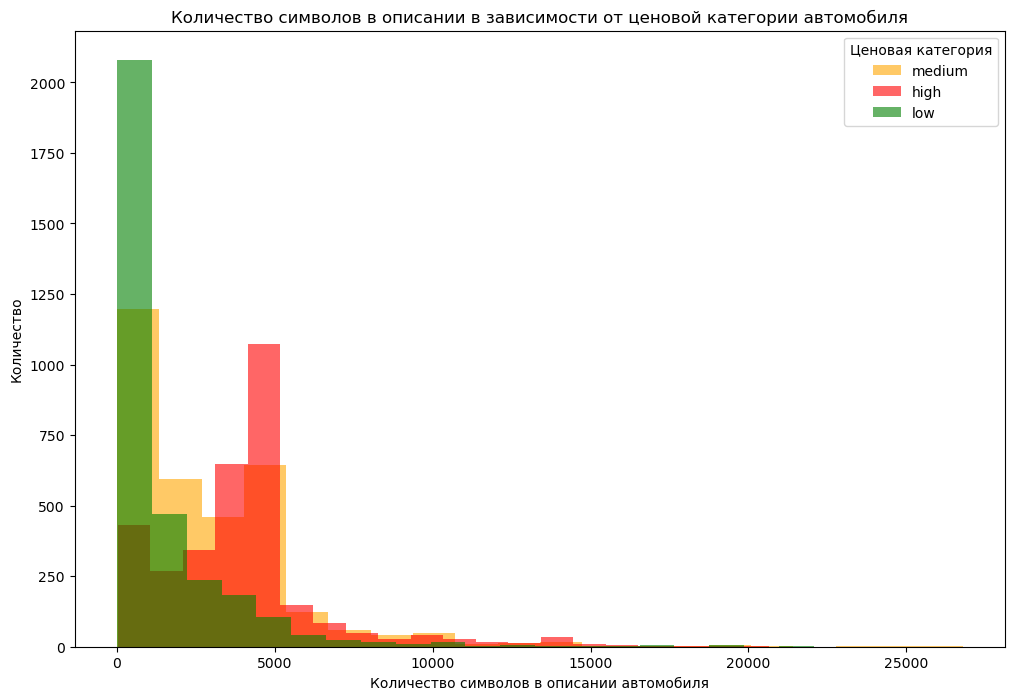

In [50]:
colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(12, 8))
for price_category in colors:
    color = colors[price_category]
    data = df[df['price_category'] == price_category]

    ax.hist(data['desc_len'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество символов в описании автомобиля')
plt.title('Количество символов в описании в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

In [51]:
# Как часто в описании встречается модель
df['model_in_desc'] = df.apply(lambda x: x.description.count(x.model) , axis=1)
df['model_in_desc']

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: model_in_desc, Length: 9659, dtype: int64

In [52]:
# Возрастная категория автомобиля age_category
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)
df[['year', 'age_category']]

,year,age_category
0,2020,new
1,2016,new
2,2017,new
3,2013,average
4,2021,new
...,...,...
9995,2002,old
9996,2008,average
9997,2011,average
9998,2015,new


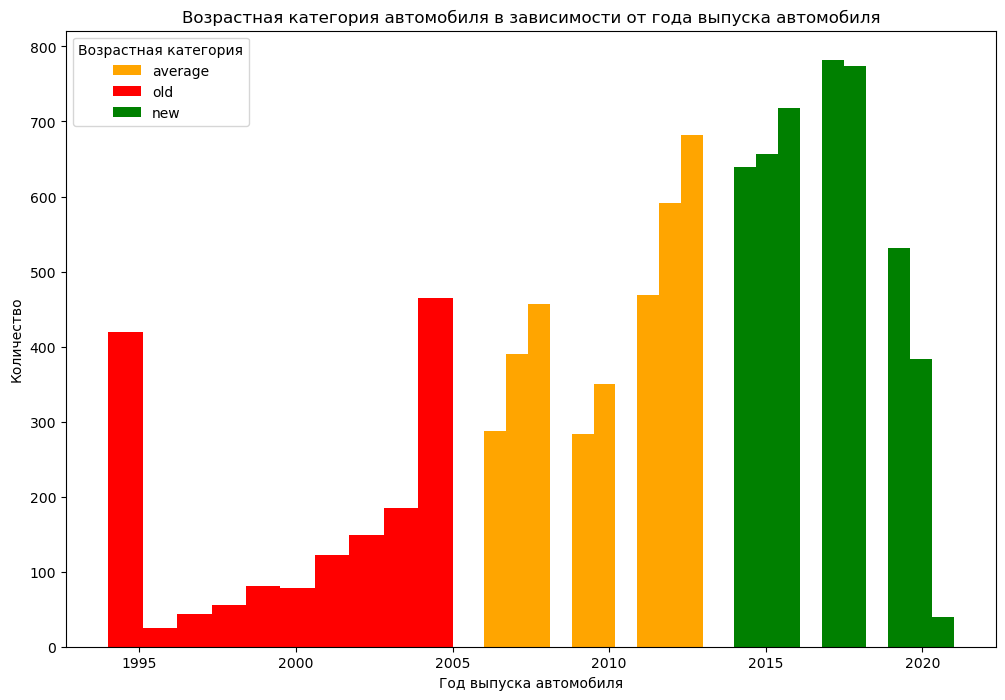

In [53]:
colors = {'average': 'orange', 'old': 'red', 'new': 'green'}

fig, ax = plt.subplots(figsize=(12, 8))
for age_category in colors:
    color = colors[age_category]
    data = df[df['age_category'] == age_category]

    ax.hist(data['year'], color=color)

plt.ylabel('Количество')
plt.xlabel('Год выпуска автомобиля')
plt.title('Возрастная категория автомобиля в зависимости от года выпуска автомобиля')
plt.legend(colors, title="Возрастная категория");

In [54]:
df['model'].nunique()

3357

In [55]:
# Количество уникадьных значений для модели велико. Сократим их, оставив первое слово в наименовании модели
df['short_model'] = df['model'].apply(lambda x: x.split(' ') [0])
df['short_model'].nunique()

948

In [56]:
# Создим новый признак model_len, обозначающий количество символов (длину строки) в модели автомобиля

In [57]:
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)
df['model_len']

0       22
1       20
2       16
3        4
4        6
        ..
9995     4
9996     8
9997    25
9998     7
9999    22
Name: model_len, Length: 9659, dtype: int64

In [58]:
# Создадим новый признак model_word_count, обозначающий количество слов в модели автомобиля

In [59]:
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')), axis=1)
df['model_word_count']

0       5
1       4
2       3
3       1
4       1
       ..
9995    1
9996    1
9997    5
9998    1
9999    5
Name: model_word_count, Length: 9659, dtype: int64

In [60]:
# Для каждого выбранного производителя автомобиля создадим отдельный признак, содержащий 1, если данный автомобиль произведён именно этим производителем, и 0, если нет.

In [61]:
manufacturer_names = ['audi', 'ford', 'chevrolet', 'toyota', 'jeep', 'honda', 'nissan']

for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer

    df[col_name] = df.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

In [62]:
df.iloc[:, -7:]

,is_audi,is_ford,is_chevrolet,is_toyota,is_jeep,is_honda,is_nissan
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
9995,0,0,0,1,0,0,0
9996,0,0,0,0,1,0,0
9997,1,0,0,0,0,0,0
9998,0,0,0,0,0,0,0


 ### 3.2 Признаки на основе дат

In [63]:
# diff_years - количество лет между годом производства автомобиля и годом размещения объявления о продаже 
df['diff_years'] = df['posting_date'].apply(lambda x: x.split('-')[0]).astype(int).sub(df['year'], axis = 0)
df['diff_years']

0        1
1        5
2        4
3        8
4        0
        ..
9995    19
9996    13
9997    10
9998     6
9999     4
Name: diff_years, Length: 9659, dtype: int32

In [64]:
# признак month, обозначающий номер месяца размещения объявления о продаже автомобиля
df['month'] = df['date'].dt.month

In [65]:
# признак dayofweek, обозначающий день недели размещения объявления о продаже автомобиля
df['dayofweek'] = df['date'].dt.weekday

In [66]:
df.shape

(9659, 41)

### 3.3 Подготовка категориальных переменных

In [67]:
data = df[['fuel', 'short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']]
data

,fuel,short_model,transmission,region,manufacturer,state,title_status,age_category
0,diesel,2500,other,chattanooga,ram,tn,clean,new
1,other,explorer,automatic,north jersey,ford,nj,clean,new
2,gas,golf,other,reno / tahoe,volkswagen,ca,clean,new
3,gas,rav4,automatic,fayetteville,toyota,nc,clean,average
4,gas,altima,automatic,new york city,nissan,ny,clean,new
...,...,...,...,...,...,...,...,...
9995,gas,rav4,automatic,chautauqua,toyota,ny,clean,old
9996,gas,wrangler,other,binghamton,jeep,ny,clean,average
9997,gas,a3,automatic,salem,audi,or,clean,average
9998,hybrid,cayenne,automatic,madison,porsche,wi,clean,new


In [68]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(data[['fuel', 'short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']])

OneHotEncoder(sparse=False)

In [69]:
# Получившаяся матрица для категориальных переменных
data_new = ohe.transform(data[['fuel', 'short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']])
data_new

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [70]:
data_new.shape

(9659, 1450)

In [71]:
df[ohe.get_feature_names_out()] = data_new
df.head()

C:\Users\mamakenga\AppData\Local\Temp\ipykernel_9544\3225231176.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = data_new
C:\Users\mamakenga\AppData\Local\Temp\ipykernel_9544\3225231176.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = data_new
C:\Users\mamakenga\AppData\Local\Temp\ipykernel_9544\3225231176.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,title_status_clean,title_status_df.title_status.mode(),title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [72]:
df.shape

(9659, 1491)

### 3.4 Стандартизация данных

In [73]:
# Количественные переменные
data_quant = df[['lat', 'long', 'year', 'odometer', 'price', 'odometer/price', 'diff_years', 'desc_len', 'model_in_desc', 'model_len','model_word_count', 'month', 'dayofweek']]
data_quant

,lat,long,year,odometer,price,odometer/price,diff_years,desc_len,model_in_desc,model_len,model_word_count,month,dayofweek
0,35.060000,-85.250000,2020,27442,54990,0.499036,1,4482,0,22,5,4,5
1,40.821805,-74.061962,2016,60023,16942,3.542852,5,968,0,20,4,5,0
2,33.779214,-84.411811,2017,14048,35590,0.394718,4,4286,0,16,3,4,2
3,35.715954,-78.655304,2013,117291,14500,8.089034,8,3241,0,4,1,4,5
4,40.654800,-73.609700,2021,8000,21800,0.366972,0,538,0,6,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,42.123900,-79.189500,2002,150000,4495,33.370412,19,1710,0,4,1,4,5
9996,43.216990,-77.755610,2008,113573,14495,7.835323,13,948,0,8,1,5,0
9997,44.925908,-122.982753,2011,150184,8995,16.696387,10,909,0,25,5,4,3
9998,43.029559,-89.397796,2015,61943,31900,1.941787,6,3644,0,7,1,4,2


In [74]:
std_scaler = StandardScaler()
std_scaler.fit(data_quant)

StandardScaler()

In [75]:
std_scaled = std_scaler.transform(data_quant)
std_scaled

array([[-0.61835109,  0.48547291,  1.29787457, ...,  1.91262014,
        -0.61568588,  1.1209642 ],
       [ 0.38826262,  1.11165959,  0.6831304 , ...,  1.23700582,
         1.62420486, -1.37543745],
       [-0.84211026,  0.53238576,  0.83681644, ...,  0.5613915 ,
        -0.61568588, -0.37687679],
       ...,
       [ 1.1052682 , -1.62640294, -0.08529981, ...,  1.91262014,
        -0.61568588,  0.12240354],
       [ 0.77396735,  0.25332366,  0.52944436, ..., -0.78983713,
        -0.61568588, -0.37687679],
       [-0.33707672,  0.98639816,  0.83681644, ...,  1.91262014,
        -0.61568588,  1.1209642 ]])

In [76]:
df[['lat_std', 'long_std', 'year_std', 'odometer_std', 'price_std', 'odometer/price_std','diff_years_std', 'desc_len_std', 'model_in_desc_std', 'model_len_std','model_word_count_std', 'month_std', 'dayofweek_std']] = std_scaled  

In [77]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,odometer_std,price_std,odometer/price_std,diff_years_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,month_std,dayofweek_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,-1.071221,2.950095,-0.508840,-1.297875,0.626840,-0.155666,1.164089,1.912620,-0.615686,1.120964
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,other,60023,...,-0.553418,-0.087574,-0.401159,-0.683130,-0.646702,-0.155666,0.932887,1.237006,1.624205,-1.375437
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,-1.284089,1.401242,-0.512531,-0.836816,0.555806,-0.155666,0.470483,0.561392,-0.615686,-0.376877
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.356731,-0.282537,-0.240328,-0.222072,0.177078,-0.155666,-0.916730,-0.789837,-0.615686,1.120964
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,-1.380209,0.300278,-0.513512,-1.451561,-0.802542,-0.155666,-0.685528,-0.789837,1.624205,-1.375437


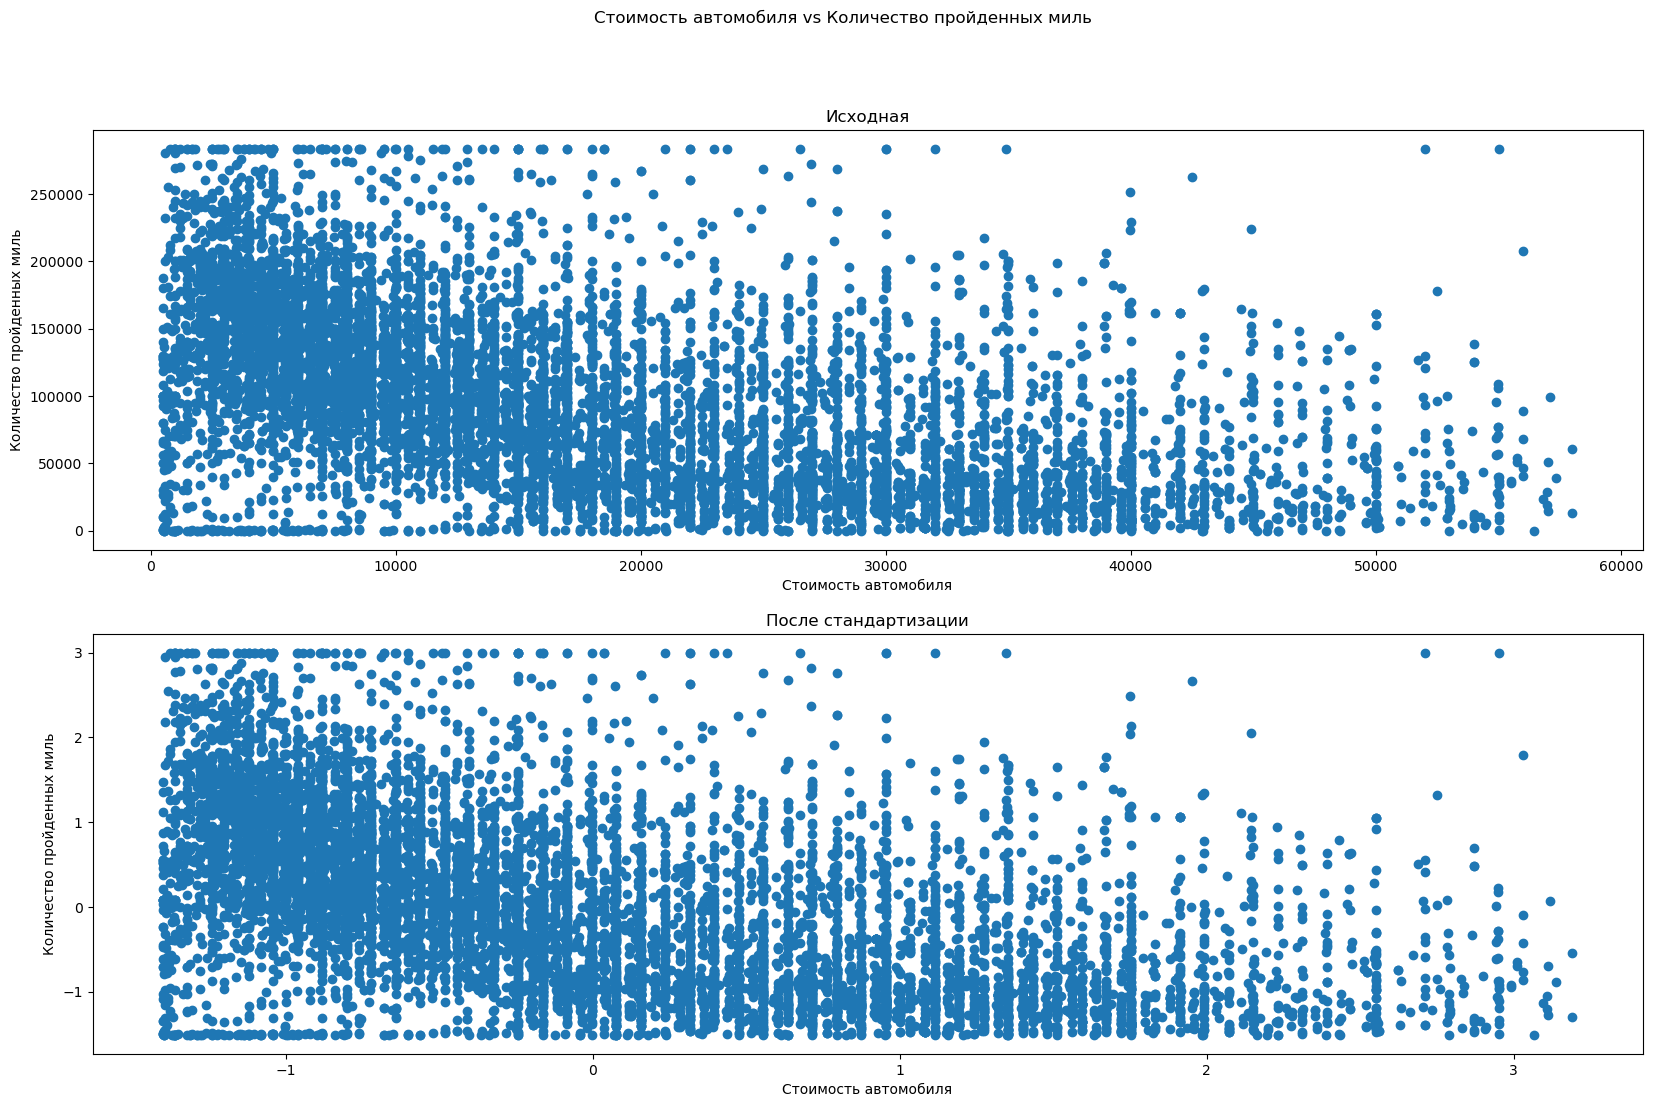

In [78]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

ax1.scatter(df.price, df.odometer)
ax1.set_title('Исходная')
ax1.set_ylabel('Количество пройденных миль')
ax1.set_xlabel('Стоимость автомобиля')


ax2.scatter(df.price_std, df.odometer_std)
ax2.set_title('После стандартизации')
ax2.set_ylabel('Количество пройденных миль')
ax2.set_xlabel('Стоимость автомобиля')

fig.suptitle('Стоимость автомобиля vs Количество пройденных миль');

In [79]:
normal_1 = df[['lat', 'lat_std', 'long', 'long_std', 'year', 'year_std', 'odometer', 'odometer_std', 'odometer/price','odometer/price_std', 'price', 'price_std']]

In [80]:
normal_2 = df[['diff_years', 'diff_years_std', 'desc_len', 'desc_len_std', 'model_in_desc', 'model_in_desc_std', 'model_len', 'model_len_std', 'model_word_count', 'model_word_count_std', 'month', 'month_std', 'dayofweek', 'dayofweek_std']]

<function matplotlib.pyplot.show(close=None, block=None)>

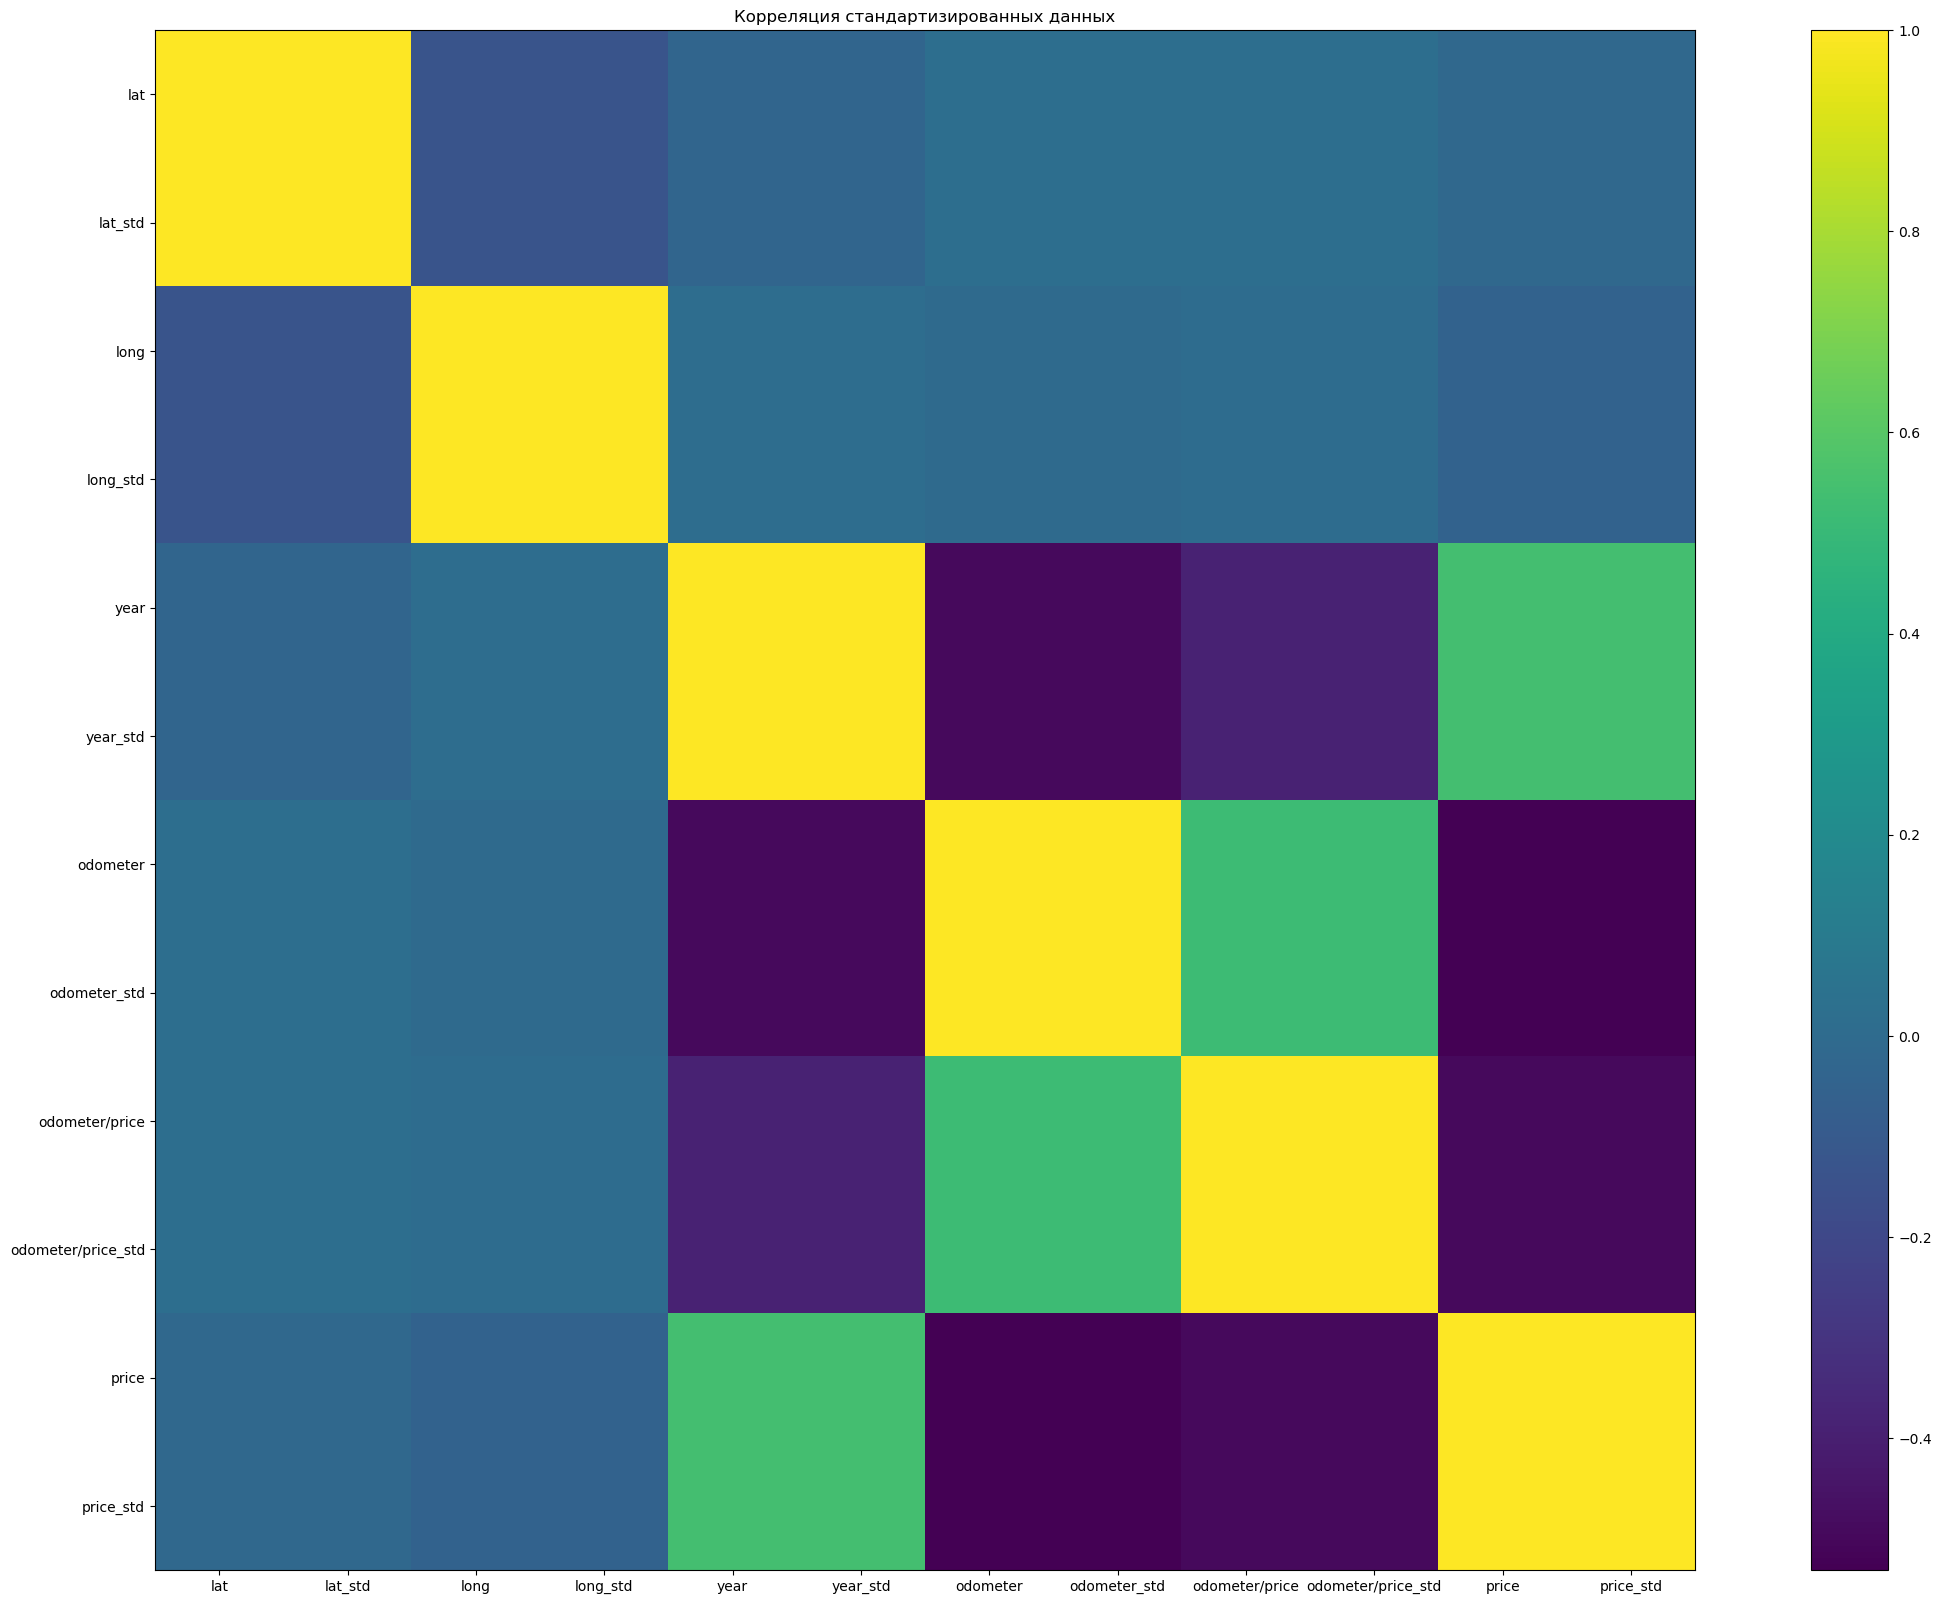

In [81]:
# Выведем матрицы корреляций для всех стандартизированных признаков

plt.figure(figsize = (30, 20))

columns = normal_1.corr().columns.tolist()
plt.imshow(normal_1.corr())

plt.title("Корреляция стандартизированных данных")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

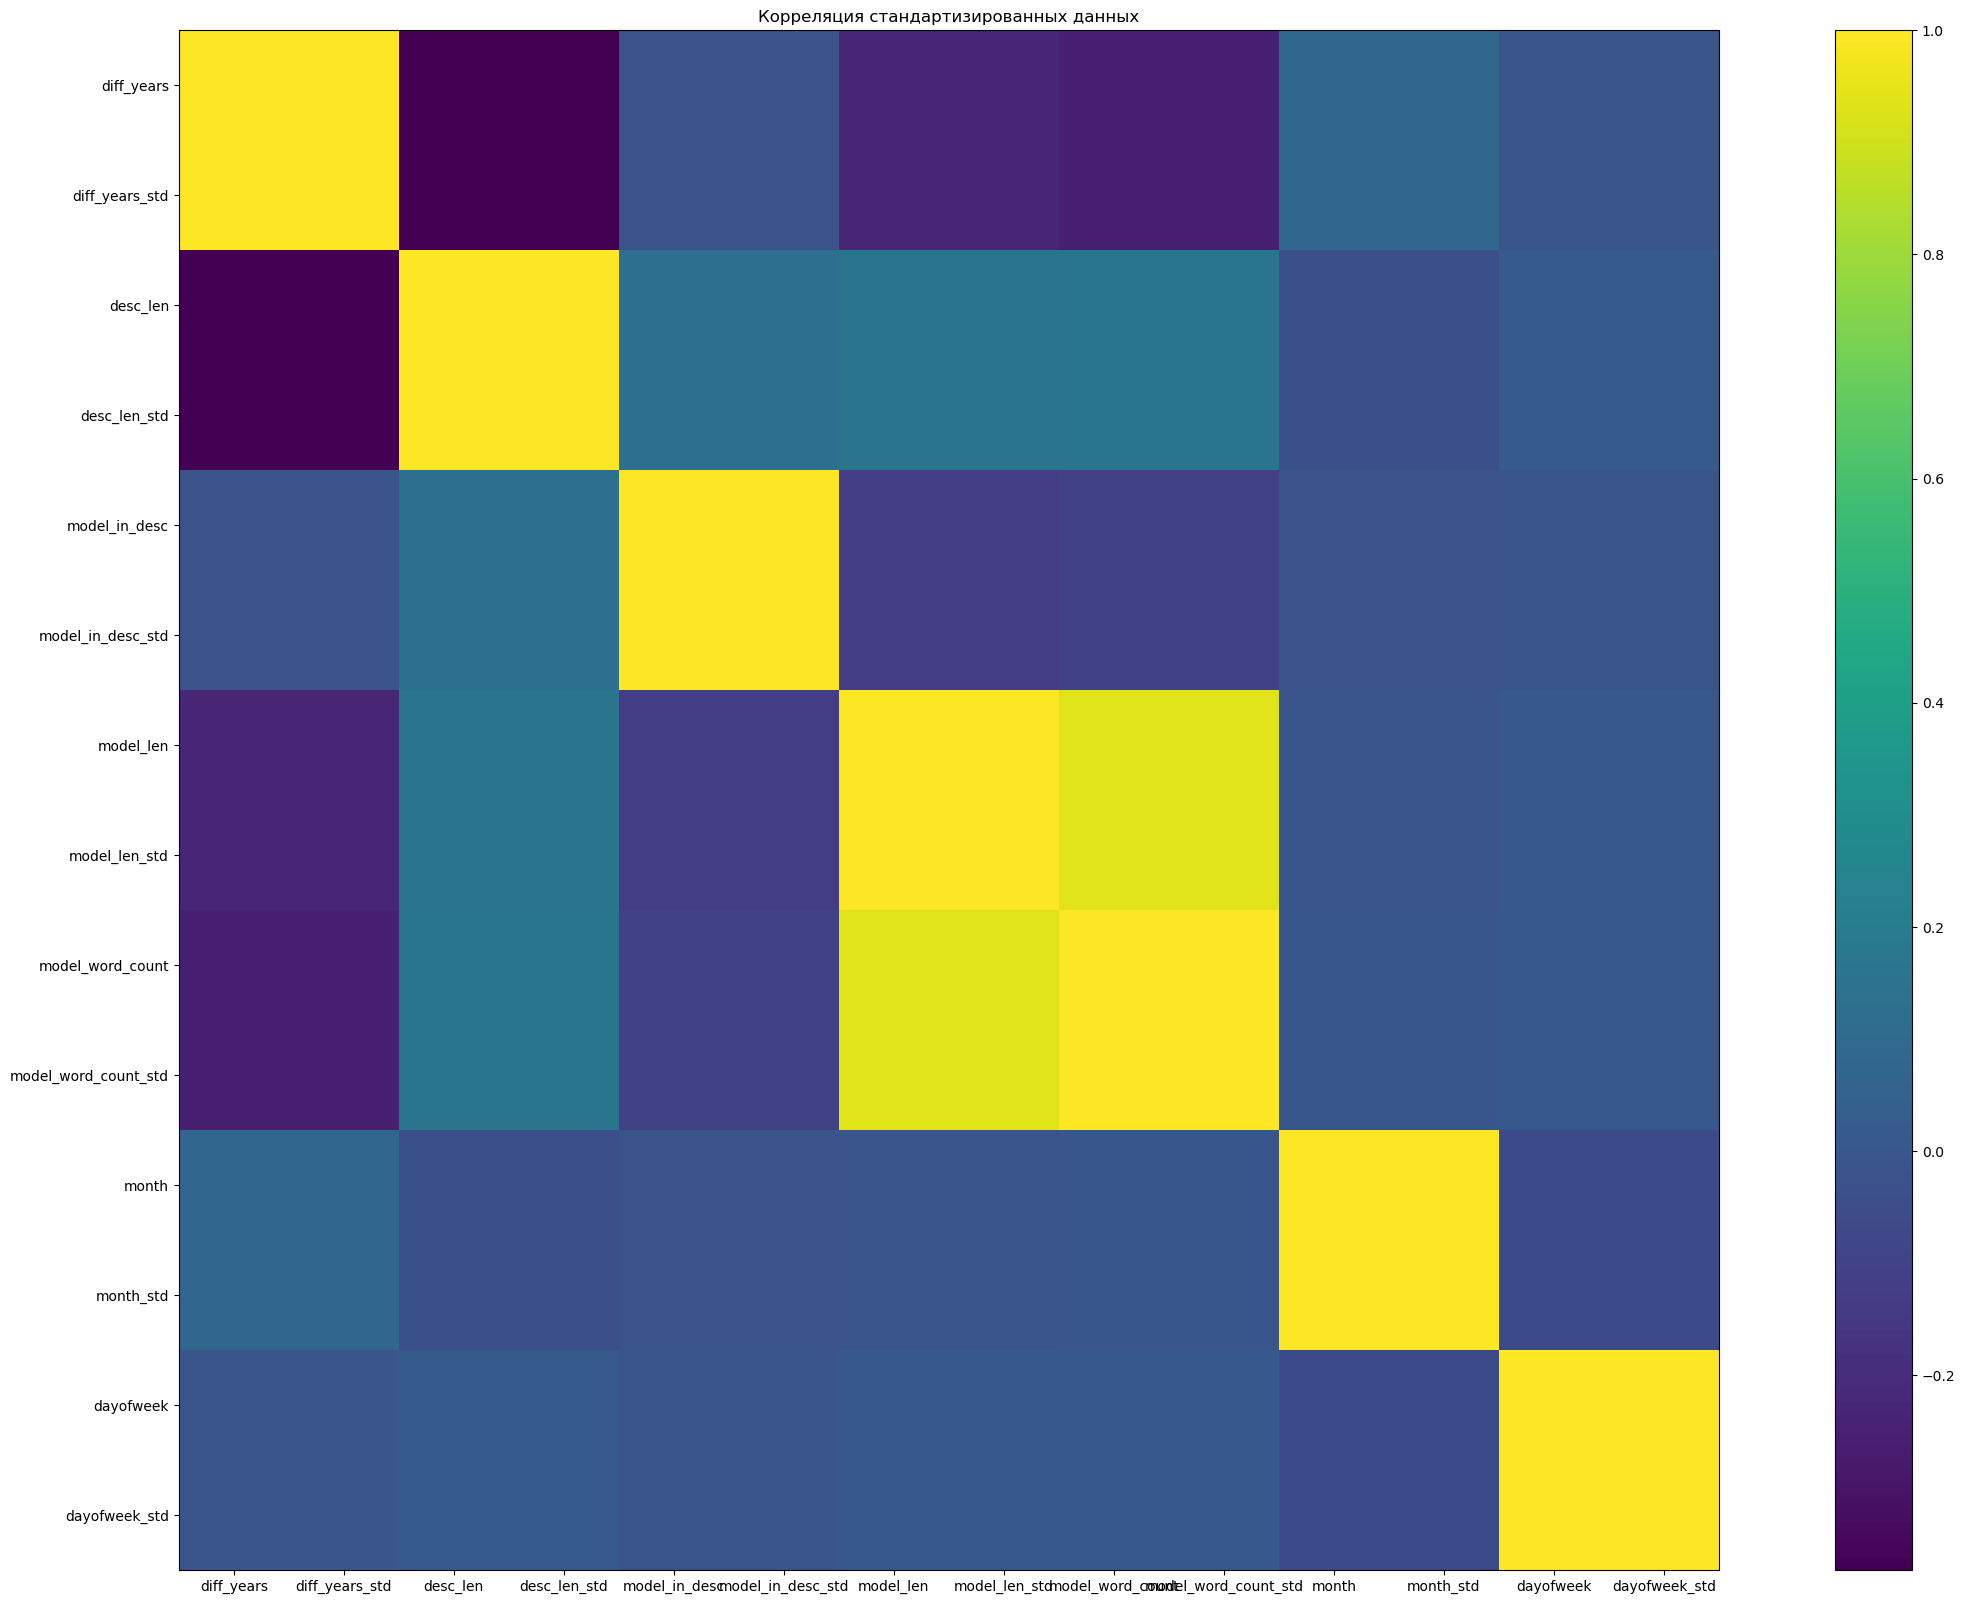

In [82]:
plt.figure(figsize = (30, 20))

columns = normal_2.corr().columns.tolist()
plt.imshow(normal_2.corr())

plt.title("Корреляция стандартизированных данных")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show

In [83]:
df.shape

(9659, 1504)

In [84]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer',
       ...
       'odometer_std', 'price_std', 'odometer/price_std', 'diff_years_std',
       'desc_len_std', 'model_in_desc_std', 'model_len_std',
       'model_word_count_std', 'month_std', 'dayofweek_std'],
      dtype='object', length=1504)

In [85]:
df_prepared = df.drop(['year', 'url', 'region', 'region_url', 'manufacturer','model', 'fuel', 'price', 'odometer', 'title_status', 'transmission', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date','odometer_km', 'odometer/price', 'region_new', 'region_corrected', 'manufacturer_model',
                    'desc_len', 'model_in_desc', 'age_category', 'model_len', 'model_word_count','short_model', 'date','month', 'dayofweek', 'diff_years'], axis = 1)

In [86]:
df_prepared.columns

Index(['id', 'price_category', 'is_audi', 'is_ford', 'is_chevrolet',
       'is_toyota', 'is_jeep', 'is_honda', 'is_nissan', 'fuel_diesel',
       ...
       'odometer_std', 'price_std', 'odometer/price_std', 'diff_years_std',
       'desc_len_std', 'model_in_desc_std', 'model_len_std',
       'model_word_count_std', 'month_std', 'dayofweek_std'],
      dtype='object', length=1472)

In [87]:
df_prepared.shape

(9659, 1472)

## 4. Modelling

In [89]:
df_learn = df_prepared.drop(['price_std', 'odometer/price_std', 'id'], axis=1)
df_learn 

,price_category,is_audi,is_ford,is_chevrolet,is_toyota,is_jeep,is_honda,is_nissan,fuel_diesel,fuel_electric,...,long_std,year_std,odometer_std,diff_years_std,desc_len_std,model_in_desc_std,model_len_std,model_word_count_std,month_std,dayofweek_std
0,high,0,0,0,0,0,0,0,1.0,0.0,...,0.485473,1.297875,-1.071221,-1.297875,0.626840,-0.155666,1.164089,1.912620,-0.615686,1.120964
1,medium,0,1,0,0,0,0,0,0.0,0.0,...,1.111660,0.683130,-0.553418,-0.683130,-0.646702,-0.155666,0.932887,1.237006,1.624205,-1.375437
2,high,0,0,0,0,0,0,0,0.0,0.0,...,0.532386,0.836816,-1.284089,-0.836816,0.555806,-0.155666,0.470483,0.561392,-0.615686,-0.376877
3,medium,0,0,0,1,0,0,0,0.0,0.0,...,0.854573,0.222072,0.356731,-0.222072,0.177078,-0.155666,-0.916730,-0.789837,-0.615686,1.120964
4,medium,0,0,0,0,0,0,1,0.0,0.0,...,1.136972,1.451561,-1.380209,-1.451561,-0.802542,-0.155666,-0.685528,-0.789837,1.624205,-1.375437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,low,0,0,0,1,0,0,0,0.0,0.0,...,0.824675,-1.468474,0.876569,1.468474,-0.377787,-0.155666,-0.916730,-0.789837,-0.615686,1.120964
9996,medium,0,0,0,0,1,0,0,0.0,0.0,...,0.904929,-0.546358,0.297642,0.546358,-0.653950,-0.155666,-0.454326,-0.789837,1.624205,-1.375437
9997,low,1,0,0,0,0,0,0,0.0,0.0,...,-1.626403,-0.085300,0.879493,0.085300,-0.668085,-0.155666,1.510893,1.912620,-0.615686,0.122404
9998,high,0,0,0,0,0,0,0,0.0,0.0,...,0.253324,0.529444,-0.522903,-0.529444,0.323133,-0.155666,-0.569927,-0.789837,-0.615686,-0.376877


In [90]:
# Инициализируем фичи и целевую переменную (price_category)
x = df_learn.drop(['price_category'], axis=1)
y = df_learn['price_category']

In [91]:
# разделяем данные на треин и тест
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### 4.1 Модель случайного леса

In [118]:
rf_clf = RandomForestClassifier(max_features = 'log2', min_samples_leaf = 1, n_estimators = 700)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=700)

In [119]:
# Удаляем фичи с нулевыми весами по feature_importance
f_imp_list = list(zip(x_train.columns, rf_clf.feature_importances_))
f_imp_list_0 = [f_imp_list[0] for f_imp_list in f_imp_list if f_imp_list[1] == 0]

In [120]:
# Предикты на тестовой и тренировочной выборках и точность модели 
predicted_train_rf = rf_clf.predict(x_train)
print('Точность модели на тренировочной выборке:', accuracy_score(y_train, predicted_train_rf))

predicted_test_rf = rf_clf.predict(x_test)
print('Точность модели на тестовой выборке:', accuracy_score(y_test, predicted_test_rf))

Точность модели на тренировочной выборке: 1.0
Точность модели на тестовой выборке: 0.766735679779158


In [102]:
# Матрица ошибок
confusion_matrix(y_test, predicted_test_rf)

array([[818,  24, 134],
       [ 24, 806, 109],
       [147, 235, 601]], dtype=int64)

### 4.2 Модель логистической регрессии

In [121]:
logreg = LogisticRegression(C = 3, max_iter = 1000)
logreg.fit(x_train, y_train)

LogisticRegression(C=3, max_iter=1000)

In [122]:
# Предикты на тестовой и тренировочной выборках и точность модели 
logreg_train_pred = logreg.predict(x_train)
print('Точность модели на тренировочной выборке:', accuracy_score(y_train, logreg_train_pred))

logreg_test_pred = logreg.predict(x_test)
print('Точность модели на тестовой выборке:', accuracy_score(y_test, logreg_test_pred))

Точность модели на тренировочной выборке: 0.8732436030173051
Точность модели на тестовой выборке: 0.7677708764665286


In [123]:
# Матрица ошибок
confusion_matrix(y_test, logreg_test_pred)

array([[821,  19, 136],
       [ 35, 753, 151],
       [140, 192, 651]], dtype=int64)

### 4.3 Модель многослойного персептрона

In [124]:
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(100,10), activation = 'tanh')
mlp.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 10), max_iter=500)

In [125]:
# Предикты на тестовой и тренировочной выборках и точность модели 
mlp_train_pred = mlp.predict(x_train)
print('Точность модели на тренировочной выборке:', accuracy_score(y_train, mlp_train_pred))

mlp_test_pred = mlp.predict(x_test)
print('Точность модели на тестовой выборке:', accuracy_score(y_test, mlp_test_pred))

Точность модели на тренировочной выборке: 0.9902381304540748
Точность модели на тестовой выборке: 0.7732919254658385


In [126]:
# Матрица ошибок
confusion_matrix(y_test, mlp_test_pred)

array([[828,  23, 125],
       [ 33, 736, 170],
       [153, 153, 677]], dtype=int64)

### 4.4 Кросс-валидация

In [143]:
# Для модели случайного леса
cv_score_rf = cross_val_score(rf_clf, x, y, cv=5)
cv_score_rf

array([0.77587992, 0.7815735 , 0.77587992, 0.77432712, 0.77628172])

In [142]:
# Для модели логистической регрессии
cv_score_logreg = cross_val_score(logreg, x, y, cv=5)
cv_score_logreg 

array([0.77536232, 0.77432712, 0.77122153, 0.76863354, 0.77628172])

In [138]:
# Для модели многослойного персептрона
cv_score_mlp = cross_val_score(mlp, x, y, cv=5)
cv_score_mlp 

array([0.78519669, 0.77639752, 0.78623188, 0.77484472, 0.78560331])

In [144]:
print('Средннее значение и отклонение для Случайного леса:', cv_score_rf.mean(), cv_score_rf.std())
print('Средннее значение и отклонение для Логистической регресси:', cv_score_logreg.mean(), cv_score_logreg.std())
print('Средннее значение и отклонение для Многослойного персептрона:', cv_score_mlp.mean(), cv_score_mlp.std())

Средннее значение и отклонение для Случайного леса: 0.7767884349605916 0.0024844503659378213
Средннее значение и отклонение для Логистической регресси: 0.7731652465547947 0.0028356258866984113
Средннее значение и отклонение для Многослойного персептрона: 0.781654824359663 0.0049618878062151145


In [ ]:
# модели не перееобучены и дают хорошие результаты

## 5. Results

In [145]:
# по результатам моделирования наилучший результат показала модель многослойного персептрона

In [146]:
mlp.fit(x, y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 10), max_iter=500)